In [4]:
# configuration parameters for Times square
last_data_date = 'Now'
duration_in_day = 1
OverViewOnly = True

In [5]:
from matplotlib import pyplot as plt

from lsst_efd_client import EfdClient,resample
import numpy as np
import pandas as pd
import datetime 
import pytz
timezone = pytz.utc
from math import isnan
import asyncio


In [6]:
# initialisation from 
if last_data_date == 'Now':
    last_data_date_val = datetime.datetime.now(datetime.UTC)
else:
    last_data_date_val = datetime.datetime.fromisoformat(last_data_date+'T14:00:00+00:00')
first_data_date_val = last_data_date_val - datetime.timedelta(days=duration_in_day)
#
tstart=first_data_date_val.isoformat()
tend=last_data_date_val.isoformat()
# save plot on file
save_fig=False
# show plot on screen 
show_it = True
#
day_ref=datetime.datetime.fromisoformat(tstart).replace(tzinfo=None)
print( 'we will analyse data between ',tstart,' and ',tend,' using FES configuration at ', day_ref)
run_cur='%s_%s' % (first_data_date_val.isoformat(),last_data_date_val.isoformat())
#
# ------------- initialisation 
# --- Manual configuration  ( to be edited by hand )  
#
#
output_data='/home/a/antilog/public_html/LsstCam/fes/'
#
# --- Automated configuration 
client = EfdClient('usdf_efd')
#
if save_fig  :
    print('Output will be saved in %s%s' % (output_data,run_cur))
#---------
manual=False
#
socket_name=[]
for i in range(5) : 
    socket_name.append('socket%d' % (i+1))
#


we will analyse data between  2026-01-05T16:16:37.489617+00:00  and  2026-01-07T16:16:37.489617+00:00  using FES configuration at  2026-01-05 16:16:37.489617


In [7]:
#
def SaveFig(fig,File,run_cur='',raft_cur='',ccd_cur='',hdu=''):
    if len(hdu)==0 : 
        root_plt=os.path.join(output_data,run_cur,raft_cur,ccd_cur)
    else : 
        hdu_cur='%s' % (hdu)
        root_plt=os.path.join(output_data,run_cur,raft_cur,ccd_cur,hdu_cur)
    # 
    PlotFile=File.replace('.','_')
    PlotFile=PlotFile.replace(' ','_')
    os.makedirs(root_plt,exist_ok=True)
    plotfile=os.path.join(root_plt,PlotFile)
    print ('PlotFile=',plotfile)
    fig.savefig(plotfile,bbox_inches='tight')
    plt.close(fig) 
    return


In [8]:
async def read_db(query,verbose=False,clean=True) :
    if verbose : print(query)
    db_in =  await client.influx_client.query(query)
    for col in db_in.columns :
        len_col=len(db_in[db_in[col].notnull()])
        if clean :
            if len_col==0 : 
                db_in.drop(columns=[col],inplace=True)
                txt='dropped'
            else :
                txt='kept'
        else :
            txt='kept'  
        if verbose : print('%s (%s) = %d ' % (col,txt,len_col) )
    return db_in 

In [9]:
#========= fill the DB for unlock data 
query = '''SELECT * FROM "lsst.MTCamera"."autogen"."lsst.MTCamera.fcs_canbus_controller" WHERE  time > '%s' AND time < '%s' AND "Agent"='fcs' AND "Canbus"='canbus0' AND ("Controller"='clampXminusController' OR "Controller"='clampXplusController') AND "Hardware"='carousel' ''' % (tstart,tend)
cl_car  = await read_db(query)
#
query = '''SELECT * FROM "lsst.MTCamera"."autogen"."lsst.MTCamera.fcs_carousel_clamp" WHERE  time > '%s' AND time < '%s'  AND  "Hardware"='carousel' AND "Agent"='fcs' ''' % (tstart,tend)
clamp = await read_db(query)
#
unclamp_car=pd.merge_asof(cl_car[cl_car["Controller"]=="clampXminusController"],clamp[clamp['Clamp']=='Xminus'],left_index=True, right_index=True, by=["Agent"] ,suffixes=('_uc', '_cl'), tolerance=pd.Timedelta("50ms"),direction='nearest' )
#
query = '''SELECT * FROM "lsst.MTCamera"."autogen"."lsst.MTCamera.fcs_duration_carousel_clamps" WHERE  time > '%s' AND time < '%s' AND "Agent"='fcs' AND "Hardware"='carousel' ''' % (tstart,tend)
cl_duration  =  await read_db(query,clean=False)
#=== build related time information  
brake=unclamp_car['state'].to_numpy()
index_brakeOff_i=np.argwhere( (brake[0:-1]=='SWITCH_ON_DISABLED') & (brake[1:]!='SWITCH_ON_DISABLED' ))[:,0]
start_controler=unclamp_car.iloc[index_brakeOff_i].index
index_brakeOn_i=np.argwhere( (brake[0:-1]!='SWITCH_ON_DISABLED') & (brake[1:]=='SWITCH_ON_DISABLED' ))[:,0]
end_controler=unclamp_car.iloc[index_brakeOn_i].index
delta=end_controler-start_controler
deltas=np.array(delta.seconds)
good_dur=np.argwhere((deltas!=0) & (deltas<6))[:,0]

start_unclamp=unclamp_car.iloc[index_brakeOff_i[good_dur]].index
end_unclamp=unclamp_car.iloc[index_brakeOn_i[good_dur]].index



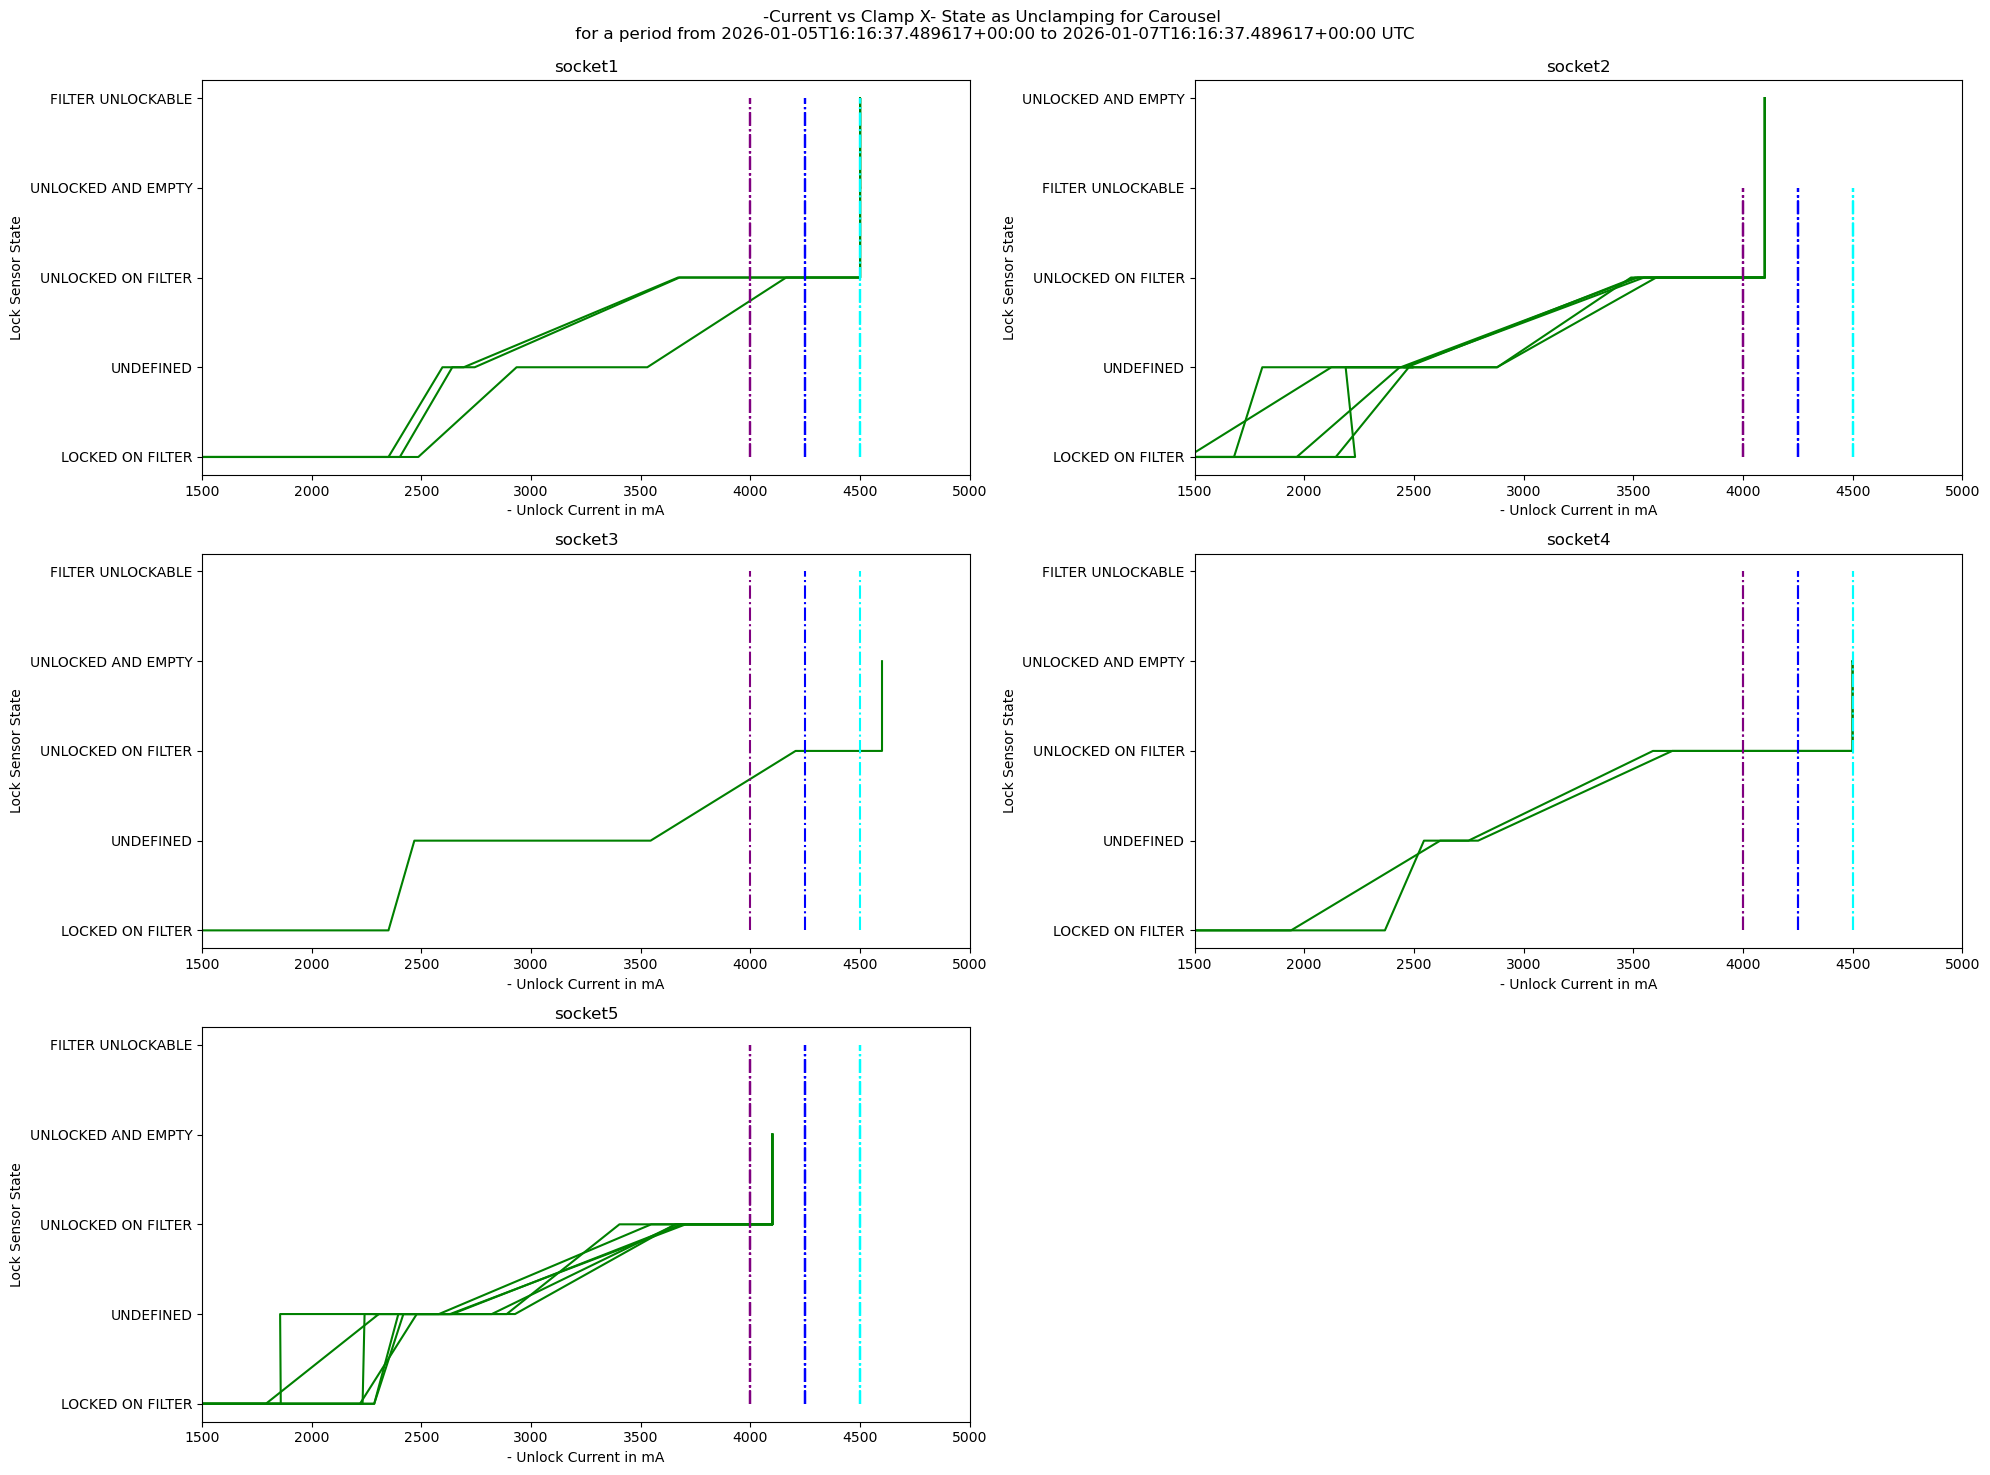

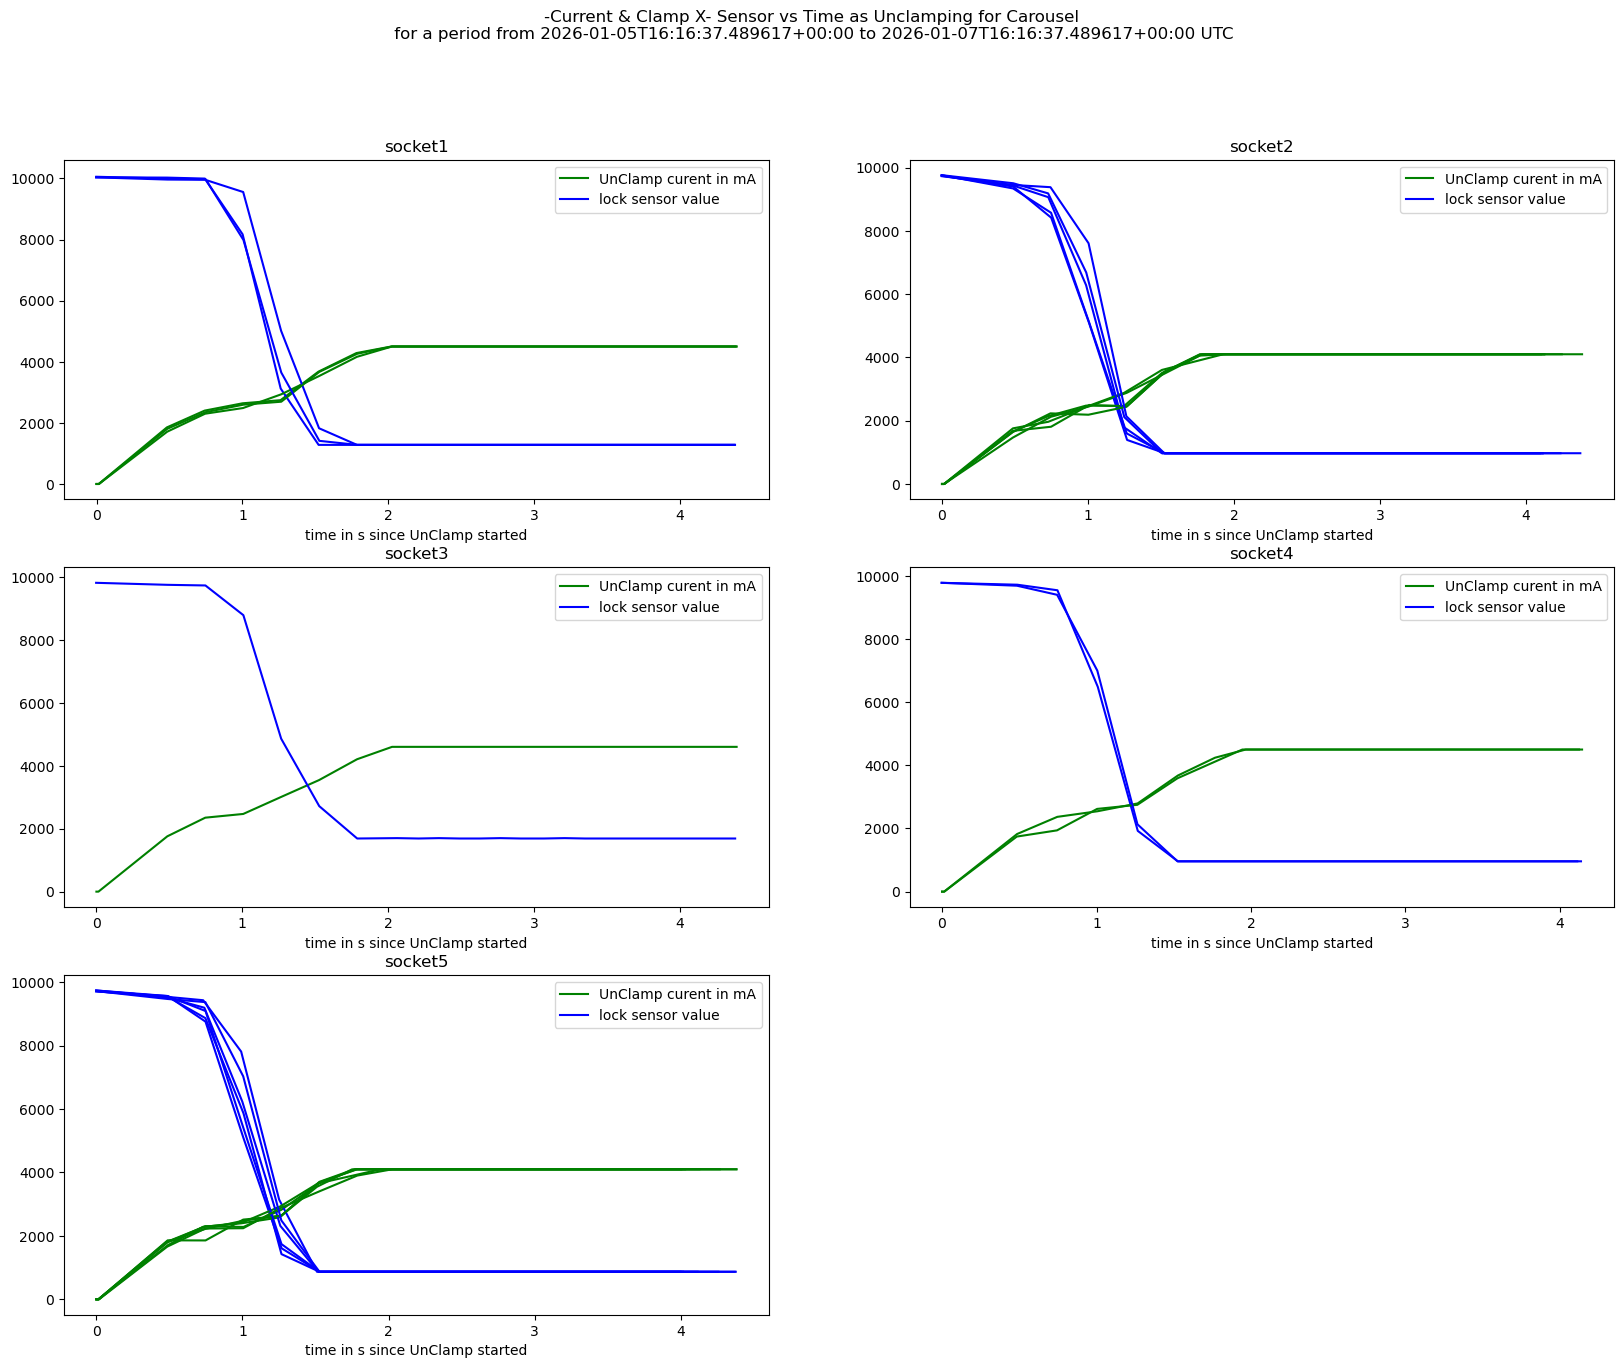

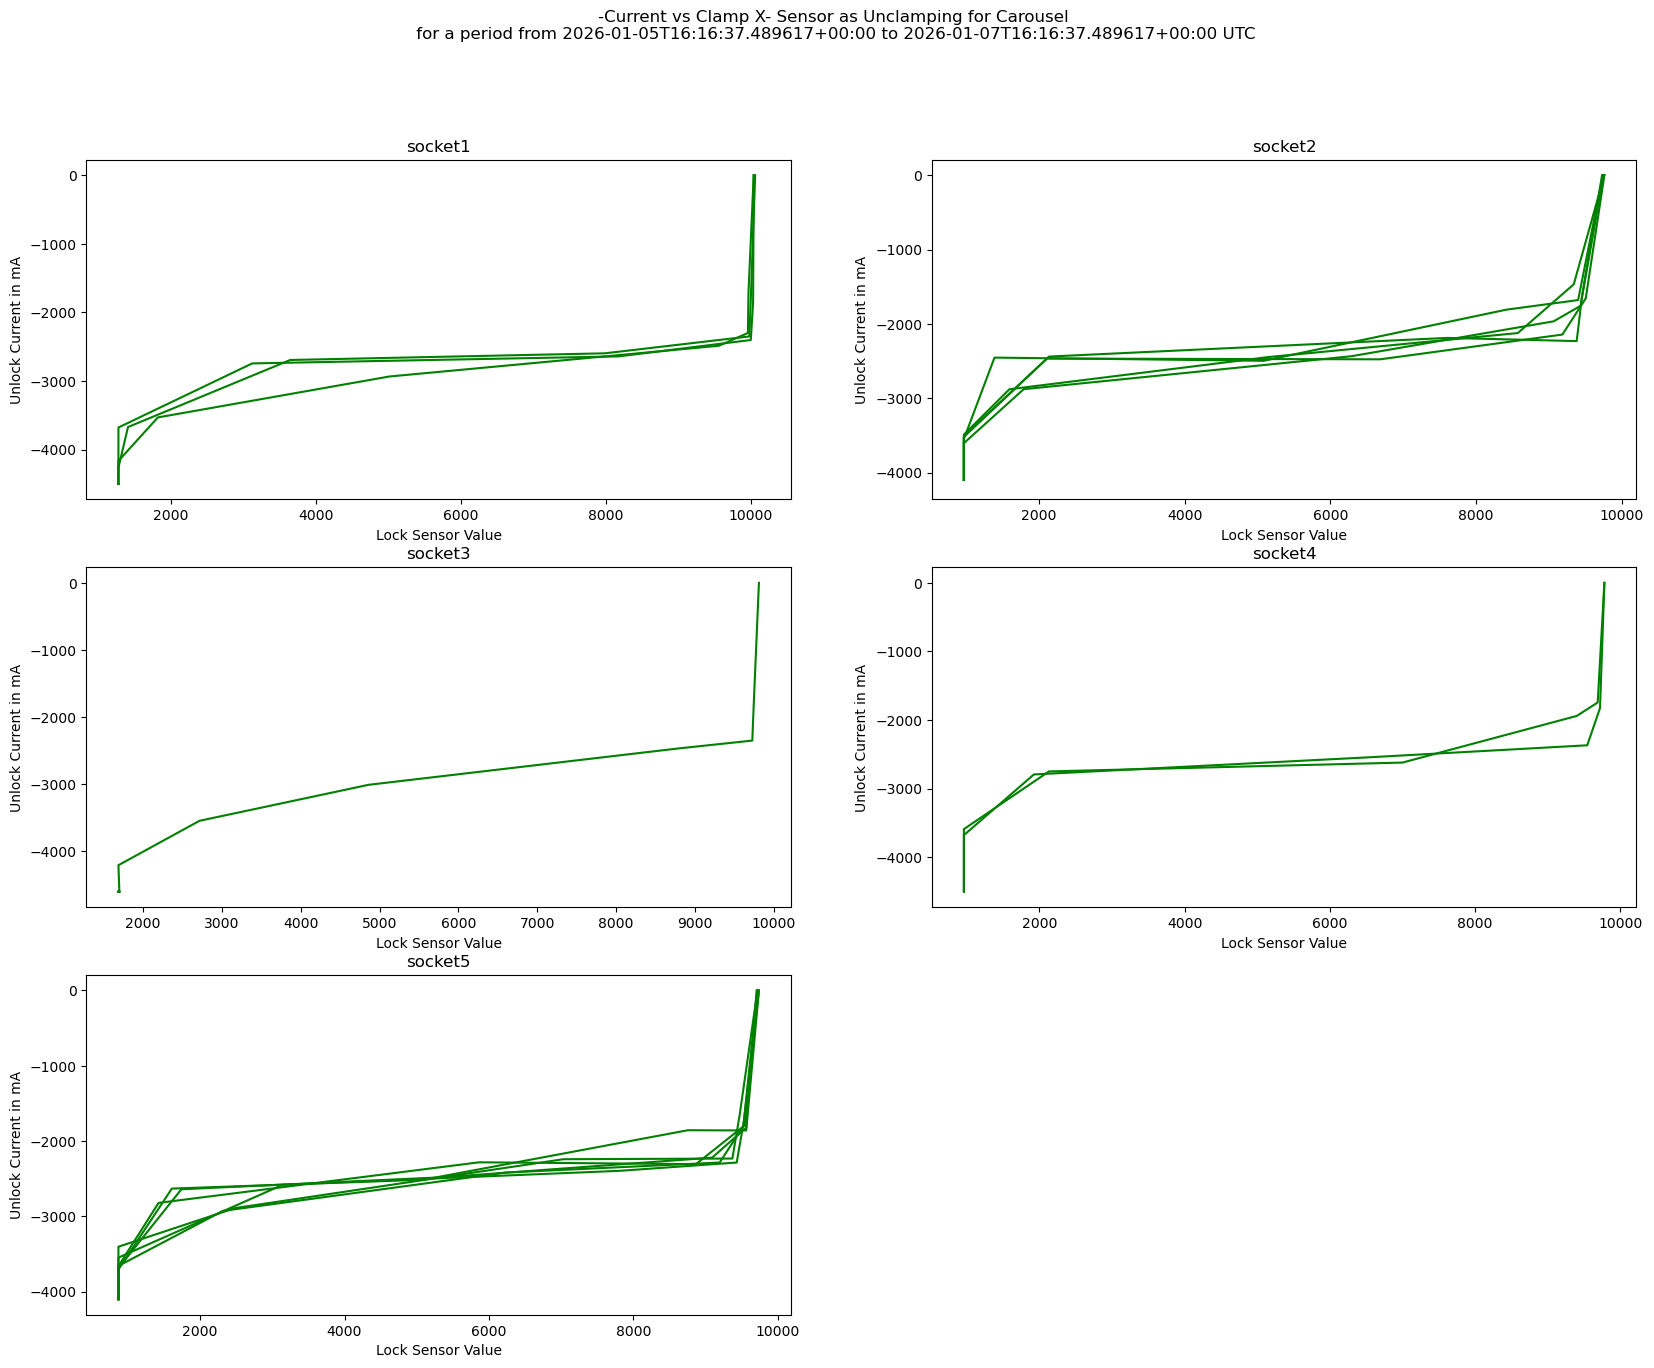

In [10]:
fig=plt.figure(figsize=(20,15))
title='-Current vs Clamp X- State as Unclamping for Carousel \n for a period from %s to %s UTC \n  ' % (tstart,tend)
fig.suptitle(title)
iso=0
for sock in socket_name  : 
    iso+=1
    plt.subplot(3,2,iso,title=sock)
    for i in range(len(start_unclamp)) :
        all_cl_cur=unclamp_car[(unclamp_car["Controller"]=="clampXminusController")  & (unclamp_car['Clamp']=='Xminus')  & (unclamp_car['Socket']==sock)] .loc[start_unclamp[i]:end_unclamp[i]]
        if len(all_cl_cur) == 0 : continue
        cl_cur=all_cl_cur['averageCurrent'].to_numpy()
        sum_cur=np.sum(cl_cur)
        if sum_cur>0 : continue 
        time_ucl= all_cl_cur['timestamp_uc'].to_numpy() 
        time_cl= all_cl_cur['timestamp_cl'].to_numpy() 
        plt.plot(-all_cl_cur['averageCurrent'],all_cl_cur['clampState'],color='g')
        #plt.plot([abs(carCL_current[iso-1]), abs(carCL_current[iso-1])],['LOCKED ON FILTER','FILTER UNLOCKABLE'],color='r')
        plt.plot([4000,4000],['LOCKED ON FILTER','FILTER UNLOCKABLE'],'-.',color='purple')
        plt.plot([4250,4250],['LOCKED ON FILTER','FILTER UNLOCKABLE'],'-.',color='b')
        plt.plot([4500,4500],['LOCKED ON FILTER','FILTER UNLOCKABLE'],'-.',color='cyan')
    plt.ylabel('Lock Sensor State')
    plt.xlim(1500.,5000.)
    plt.xlabel('- Unlock Current in mA')
plt.tight_layout()
if show_it : plt.show()
if save_fig : SaveFig(fig,File='ClampXmCurVsLockState',run_cur=run_cur,raft_cur='UnClampOnCarousel')
if not(OverViewOnly) : 
    ################
    fig=plt.figure(figsize=(20,15))
    title='-Current & Clamp X- Sensor vs Time as Unclamping for Carousel \n for a period from %s to %s UTC \n  ' % (tstart,tend)
    fig.suptitle(title)
    iso=0
    for sock in socket_name  : 
        iso+=1
        legend=True
        plt.subplot(3,2,iso,title=sock)
        for i in range(len(start_unclamp)) :
            all_cl_cur=unclamp_car[(unclamp_car["Controller"]=="clampXminusController")  & (unclamp_car['Clamp']=='Xminus')  & (unclamp_car['Socket']==sock)] .loc[start_unclamp[i]:end_unclamp[i]]
            if len(all_cl_cur) == 0 : continue
            cl_cur=all_cl_cur['averageCurrent'].to_numpy()
            sum_cur=np.sum(cl_cur)
            #print(i,start_unclamp[i],end_unclamp[i],sum_cur)
            if sum_cur>0 : continue 
            #ucl=all_cl_cur['lockSensorValue'].to_numpy()
            #ducl=ucl[1:]-ucl[0:-1]
            #iarg=np.argwhere(ducl>5000)
            #if len(iarg)>0 : 
            #    print(i,start_unclamp[i],end_unclamp[i])
            time_ucl= all_cl_cur['timestamp_uc'].to_numpy() 
            time_cl= all_cl_cur['timestamp_cl'].to_numpy() 
            if legend :
                plt.plot((time_ucl-time_ucl[0])/1000,-all_cl_cur['averageCurrent'],color='g',label='UnClamp curent in mA')
                plt.plot((time_cl-time_ucl[0])/1000,all_cl_cur['lockSensorValue'],color='b',label='lock sensor value')
                legend=False
            else :
                plt.plot((time_ucl-time_ucl[0])/1000,-all_cl_cur['averageCurrent'],color='g')
                plt.plot((time_cl-time_ucl[0])/1000,all_cl_cur['lockSensorValue'],color='b')
        plt.legend()
        plt.xlabel('time in s since UnClamp started')
    if show_it : plt.show()
    if save_fig : SaveFig(fig,File='ClampXmCurAndLockVsTime',run_cur=run_cur,raft_cur='UnClampOnCarousel')
    ###################
    fig=plt.figure(figsize=(20,15))
    title='-Current vs Clamp X- Sensor as Unclamping for Carousel \n for a period from %s to %s UTC \n  ' % (tstart,tend)
    fig.suptitle(title)
    iso=0
    for sock in socket_name  : 
        iso+=1
        plt.subplot(3,2,iso,title=sock)
        for i in range(len(start_unclamp)) :
            all_cl_cur=unclamp_car[(unclamp_car["Controller"]=="clampXminusController")  & (unclamp_car['Clamp']=='Xminus')  & (unclamp_car['Socket']==sock)] .loc[start_unclamp[i]:end_unclamp[i]]
            if len(all_cl_cur) == 0 : continue
            cl_cur=all_cl_cur['averageCurrent'].to_numpy()
            sum_cur=np.sum(cl_cur)
            if sum_cur>0 : continue 
            time_ucl= all_cl_cur['timestamp_uc'].to_numpy() 
            time_cl= all_cl_cur['timestamp_cl'].to_numpy() 
            plt.plot(all_cl_cur['lockSensorValue'],all_cl_cur['averageCurrent'],color='g')
        plt.xlabel('Lock Sensor Value')
        plt.ylabel('Unlock Current in mA')
    if show_it : plt.show()
    if save_fig : SaveFig(fig,File='ClampXmCurVsLock',run_cur=run_cur,raft_cur='UnClampOnCarousel')

In [12]:
#
unclamp_car=pd.merge_asof(cl_car[cl_car["Controller"]=="clampXplusController"],clamp[clamp['Clamp']=='Xplus'],left_index=True, right_index=True, by=["Agent"] ,suffixes=('_uc', '_cl'), tolerance=pd.Timedelta("50ms"),direction='nearest' )
#
#=== build related time information  
brake=unclamp_car['state'].to_numpy()
index_brakeOff_i=np.argwhere( (brake[0:-1]=='SWITCH_ON_DISABLED') & (brake[1:]!='SWITCH_ON_DISABLED' ))[:,0]
start_controler=unclamp_car.iloc[index_brakeOff_i].index
index_brakeOn_i=np.argwhere( (brake[0:-1]!='SWITCH_ON_DISABLED') & (brake[1:]=='SWITCH_ON_DISABLED' ))[:,0]
end_controler=unclamp_car.iloc[index_brakeOn_i].index
delta=end_controler-start_controler
deltas=np.array(delta.seconds)
good_dur=np.argwhere((deltas!=0) & (deltas<6))[:,0]

start_unclamp=unclamp_car.iloc[index_brakeOff_i[good_dur]].index
end_unclamp=unclamp_car.iloc[index_brakeOn_i[good_dur]].index



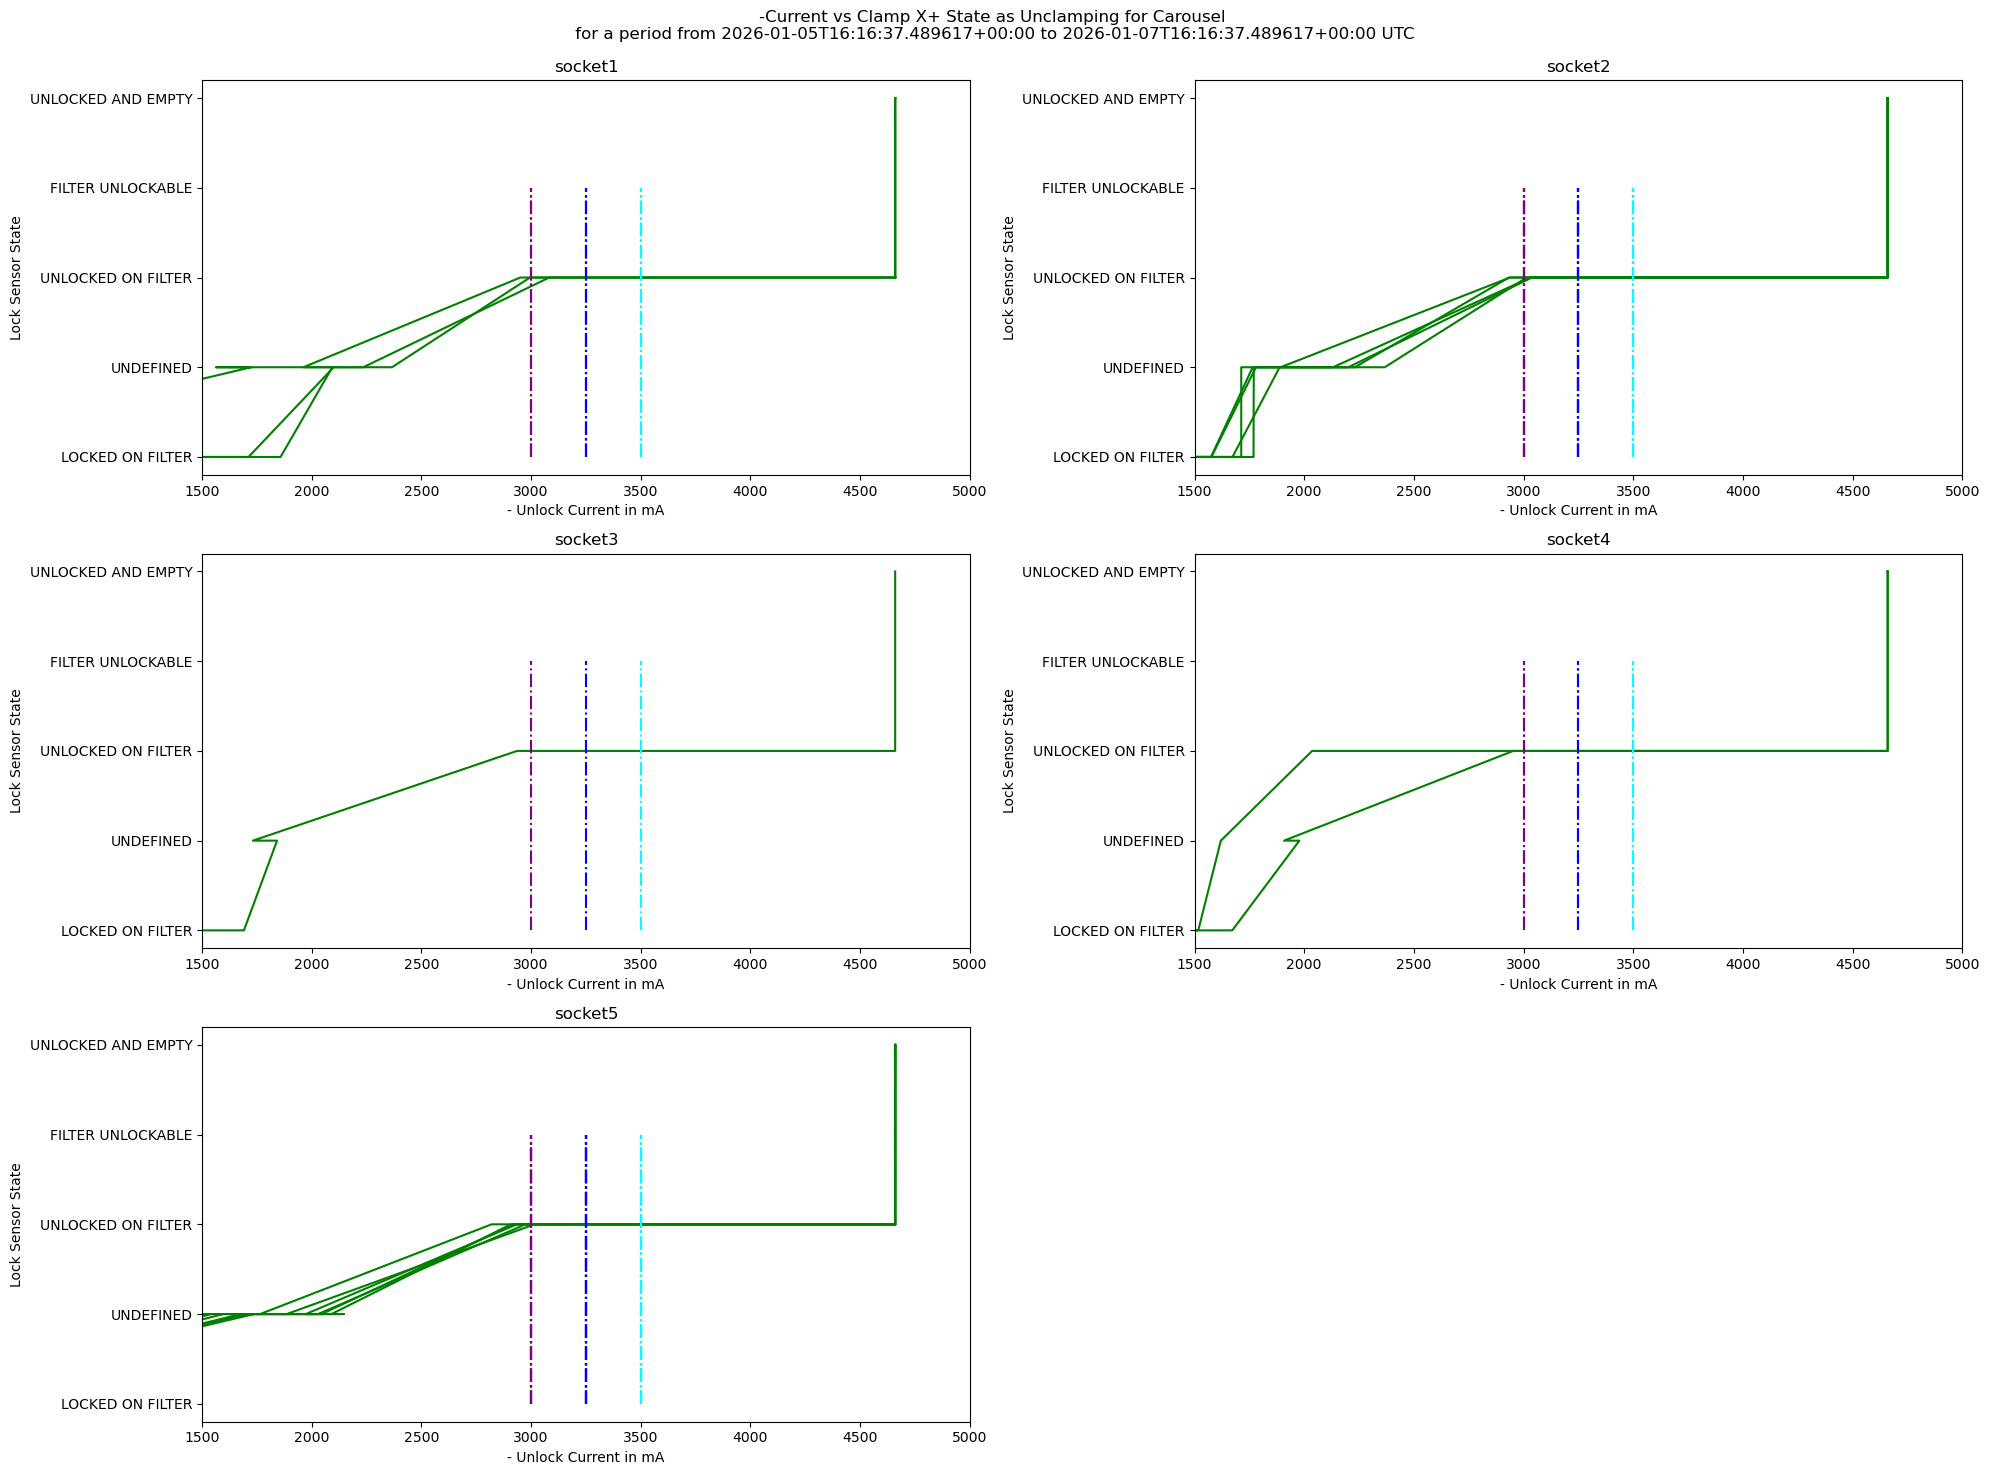

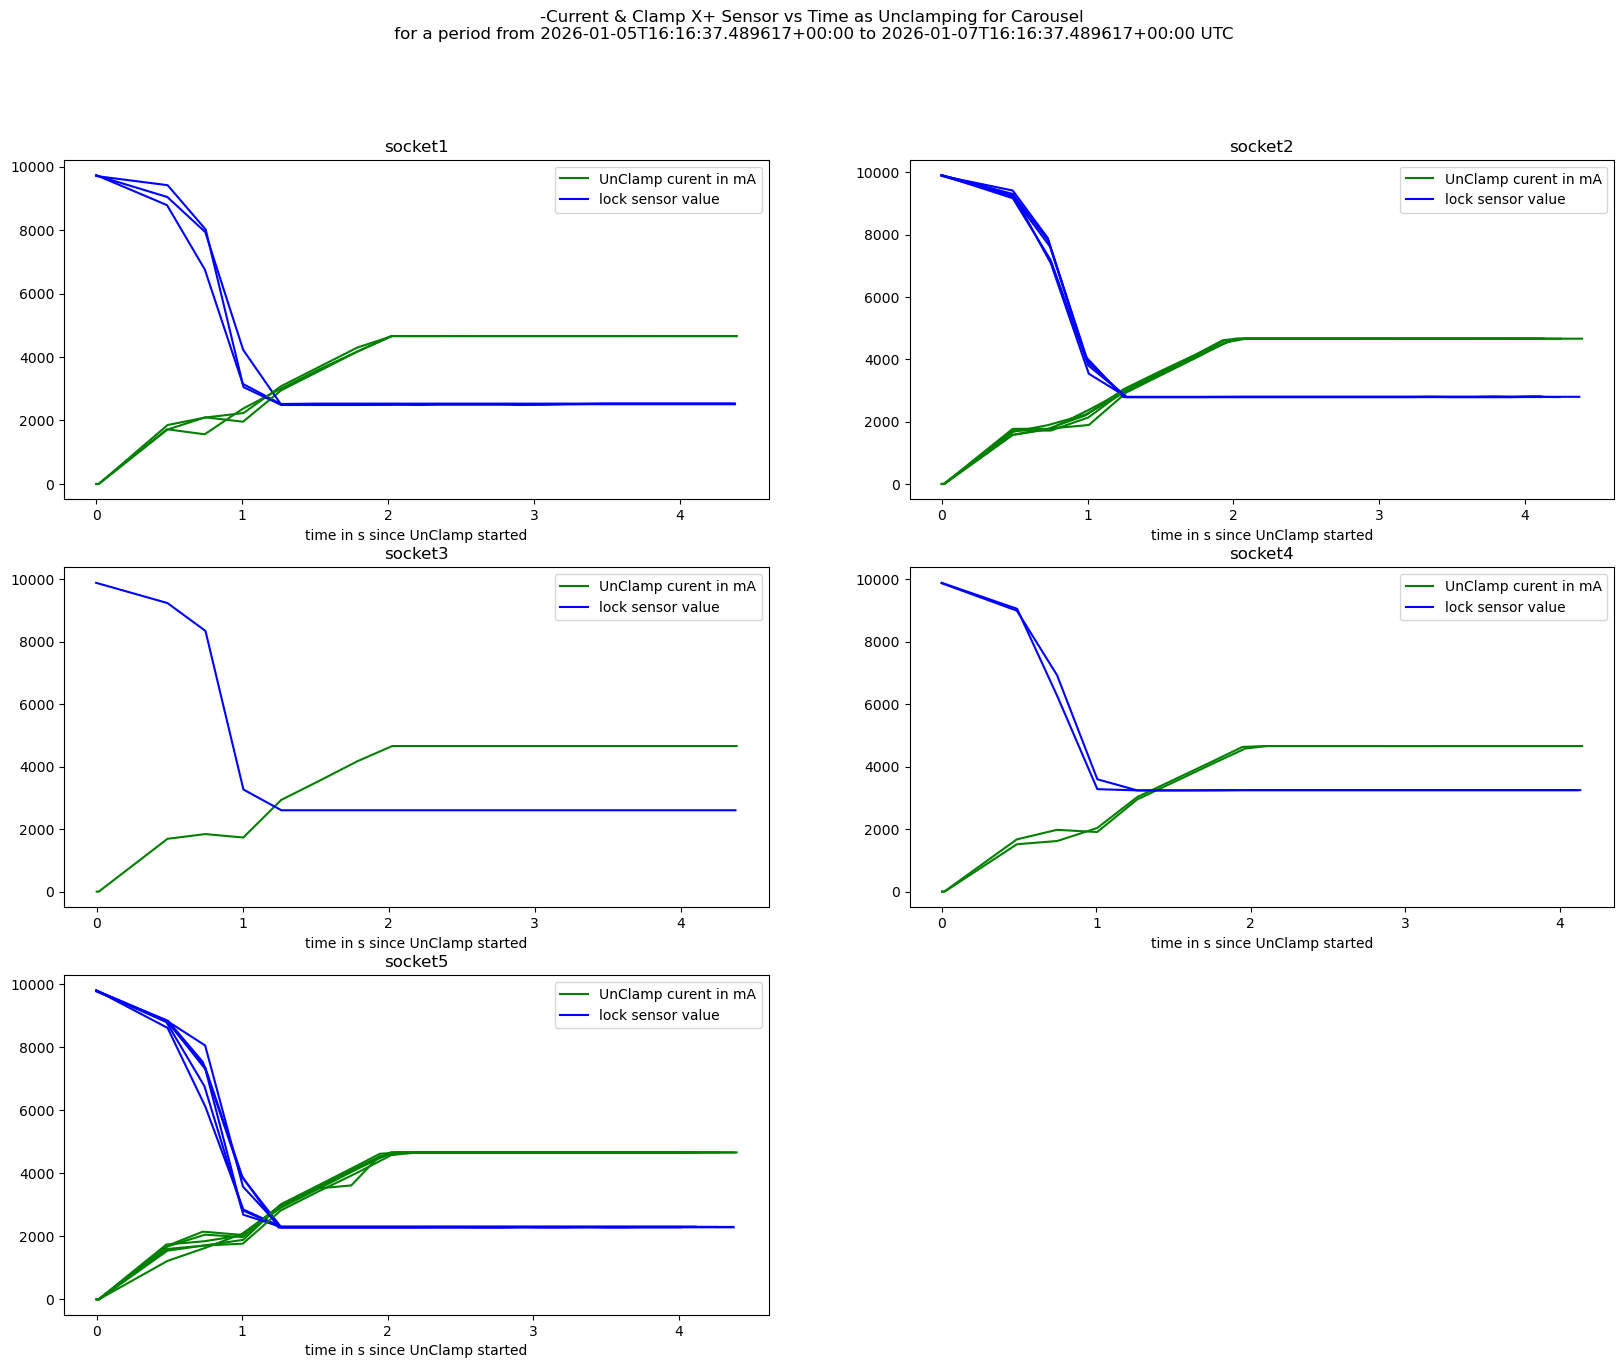

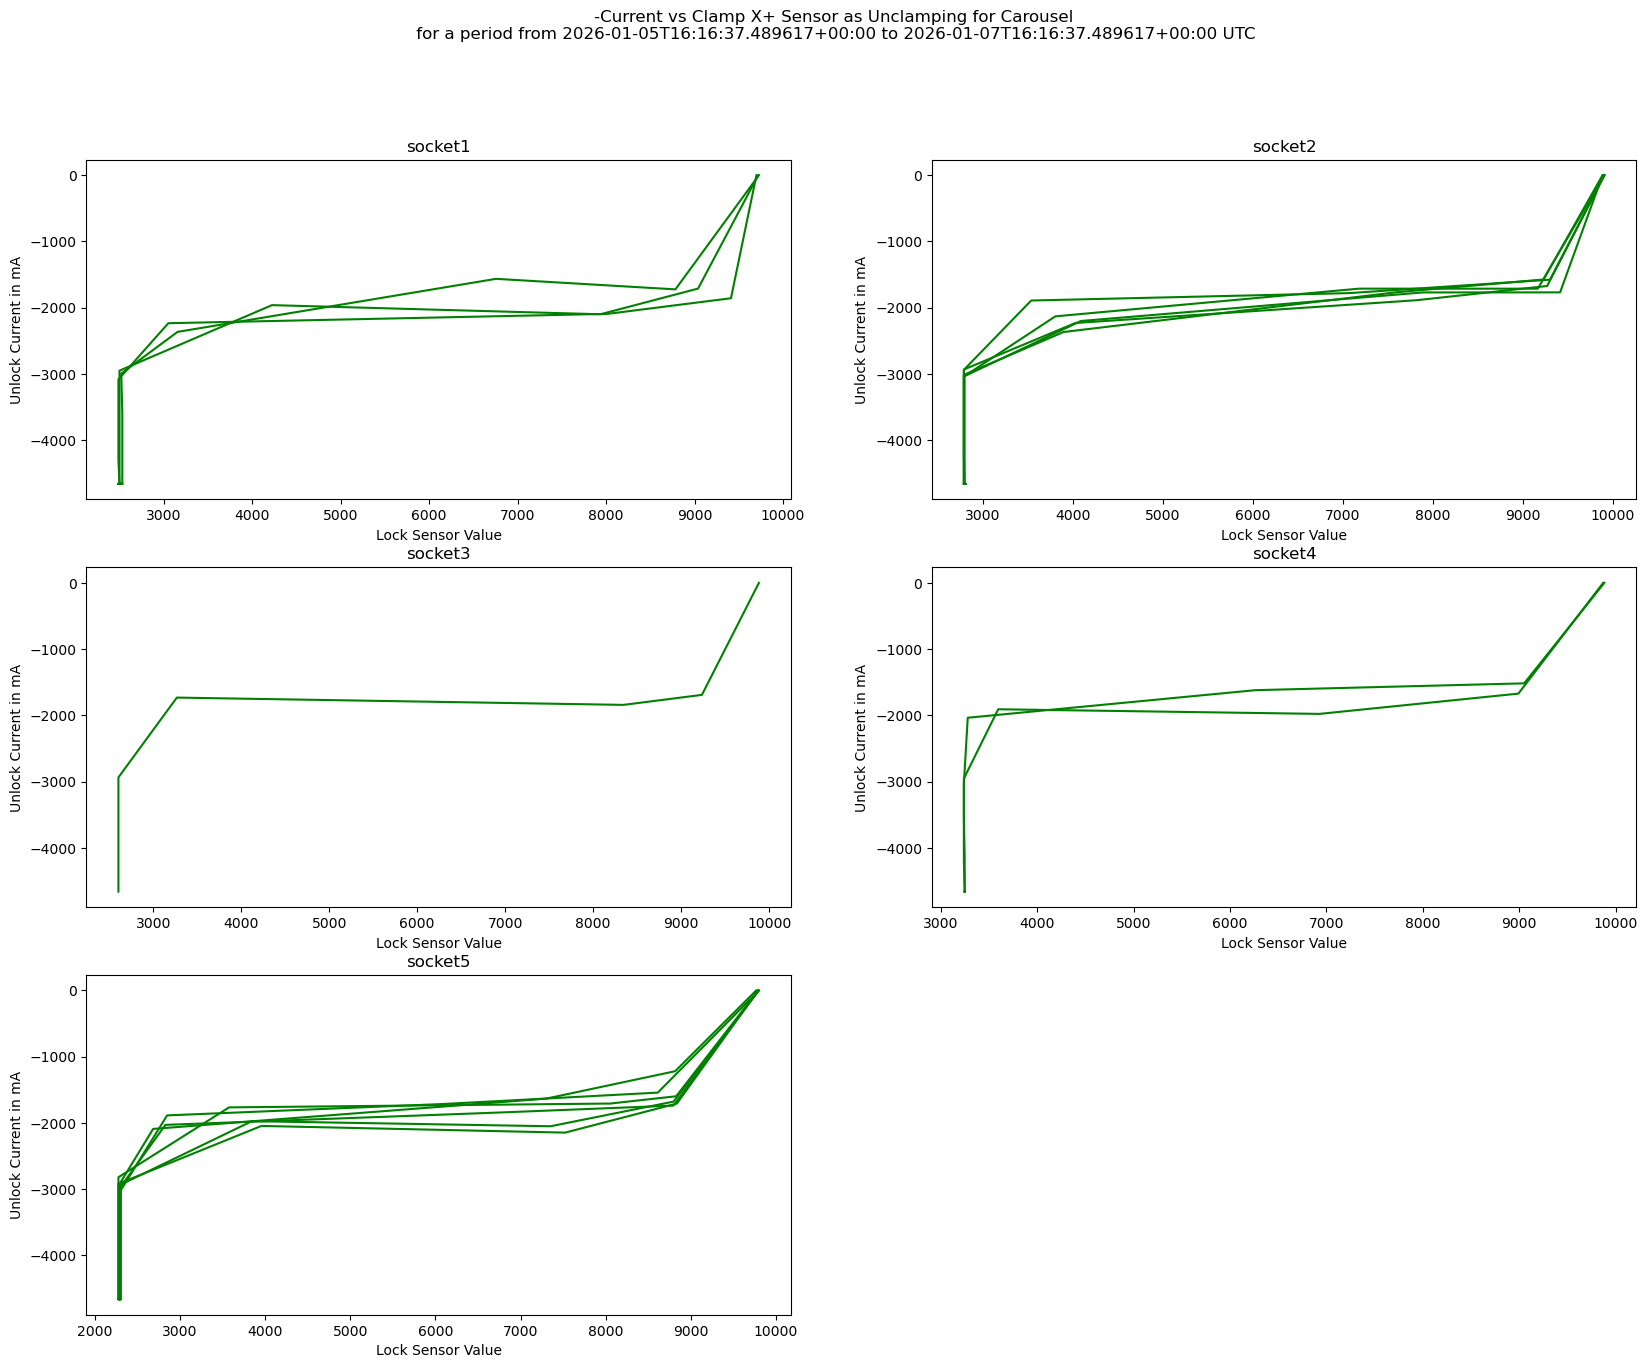

In [15]:
fig=plt.figure(figsize=(20,15))
title='-Current vs Clamp X+ State as Unclamping for Carousel \n for a period from %s to %s UTC \n  ' % (tstart,tend)
fig.suptitle(title)
iso=0
for sock in socket_name  : 
    iso+=1
    plt.subplot(3,2,iso,title=sock)
    for i in range(len(start_unclamp)) :
        all_cl_cur=unclamp_car[(unclamp_car["Controller"]=="clampXplusController")  & (unclamp_car['Clamp']=='Xplus')  & (unclamp_car['Socket']==sock)] .loc[start_unclamp[i]:end_unclamp[i]]
        if len(all_cl_cur) == 0 : continue
        cl_cur=all_cl_cur['averageCurrent'].to_numpy()
        sum_cur=np.sum(cl_cur)
        if sum_cur>0 : continue 
        time_ucl= all_cl_cur['timestamp_uc'].to_numpy() 
        time_cl= all_cl_cur['timestamp_cl'].to_numpy() 
        plt.plot(-all_cl_cur['averageCurrent'],all_cl_cur['clampState'],color='g')
        #plt.plot([abs(carCL_current[iso-1]), abs(carCL_current[iso-1])],['LOCKED ON FILTER','FILTER UNLOCKABLE'],color='r')
        plt.plot([3000,3000],['LOCKED ON FILTER','FILTER UNLOCKABLE'],'-.',color='purple')
        plt.plot([3250,3250],['LOCKED ON FILTER','FILTER UNLOCKABLE'],'-.',color='b')
        plt.plot([3500,3500],['LOCKED ON FILTER','FILTER UNLOCKABLE'],'-.',color='cyan')
    plt.ylabel('Lock Sensor State')
    plt.xlim(1500.,5000.)
    plt.xlabel('- Unlock Current in mA')
plt.tight_layout()
if show_it : plt.show()
if save_fig : SaveFig(fig,File='ClampXpCurVsLockState',run_cur=run_cur,raft_cur='UnClampOnCarousel')
if not(OverViewOnly) : 
    ################
    fig=plt.figure(figsize=(20,15))
    title='-Current & Clamp X+ Sensor vs Time as Unclamping for Carousel \n for a period from %s to %s UTC \n  ' % (tstart,tend)
    fig.suptitle(title)
    iso=0
    for sock in socket_name  : 
        iso+=1
        legend=True
        plt.subplot(3,2,iso,title=sock)
        for i in range(len(start_unclamp)) :
            all_cl_cur=unclamp_car[(unclamp_car["Controller"]=="clampXplusController")  & (unclamp_car['Clamp']=='Xplus')  & (unclamp_car['Socket']==sock)] .loc[start_unclamp[i]:end_unclamp[i]]
            if len(all_cl_cur) == 0 : continue
            cl_cur=all_cl_cur['averageCurrent'].to_numpy()
            sum_cur=np.sum(cl_cur)
            #print(i,start_unclamp[i],end_unclamp[i],sum_cur)
            if sum_cur>0 : continue 
            #ucl=all_cl_cur['lockSensorValue'].to_numpy()
            #ducl=ucl[1:]-ucl[0:-1]
            #iarg=np.argwhere(ducl>5000)
            #if len(iarg)>0 : 
            #    print(i,start_unclamp[i],end_unclamp[i])
            time_ucl= all_cl_cur['timestamp_uc'].to_numpy() 
            time_cl= all_cl_cur['timestamp_cl'].to_numpy() 
            if legend :
                plt.plot((time_ucl-time_ucl[0])/1000,-all_cl_cur['averageCurrent'],color='g',label='UnClamp curent in mA')
                plt.plot((time_cl-time_ucl[0])/1000,all_cl_cur['lockSensorValue'],color='b',label='lock sensor value')
                legend=False
            else :
                plt.plot((time_ucl-time_ucl[0])/1000,-all_cl_cur['averageCurrent'],color='g')
                plt.plot((time_cl-time_ucl[0])/1000,all_cl_cur['lockSensorValue'],color='b')
        plt.legend()
        plt.xlabel('time in s since UnClamp started')
    if show_it : plt.show()
    if save_fig : SaveFig(fig,File='ClampXpCurAndLockVsTime',run_cur=run_cur,raft_cur='UnClampOnCarousel')
    ###################
    fig=plt.figure(figsize=(20,15))
    title='-Current vs Clamp X+ Sensor as Unclamping for Carousel \n for a period from %s to %s UTC \n  ' % (tstart,tend)
    fig.suptitle(title)
    iso=0
    for sock in socket_name  : 
        iso+=1
        plt.subplot(3,2,iso,title=sock)
        for i in range(len(start_unclamp)) :
            all_cl_cur=unclamp_car[(unclamp_car["Controller"]=="clampXplusController")  & (unclamp_car['Clamp']=='Xplus')  & (unclamp_car['Socket']==sock)] .loc[start_unclamp[i]:end_unclamp[i]]
            if len(all_cl_cur) == 0 : continue
            cl_cur=all_cl_cur['averageCurrent'].to_numpy()
            sum_cur=np.sum(cl_cur)
            if sum_cur>0 : continue 
            time_ucl= all_cl_cur['timestamp_uc'].to_numpy() 
            time_cl= all_cl_cur['timestamp_cl'].to_numpy() 
            plt.plot(all_cl_cur['lockSensorValue'],all_cl_cur['averageCurrent'],color='g')
        plt.xlabel('Lock Sensor Value')
        plt.ylabel('Unlock Current in mA')
    if show_it : plt.show()
    if save_fig : SaveFig(fig,File='ClampXpCurVsLock',run_cur=run_cur,raft_cur='UnClampOnCarousel')

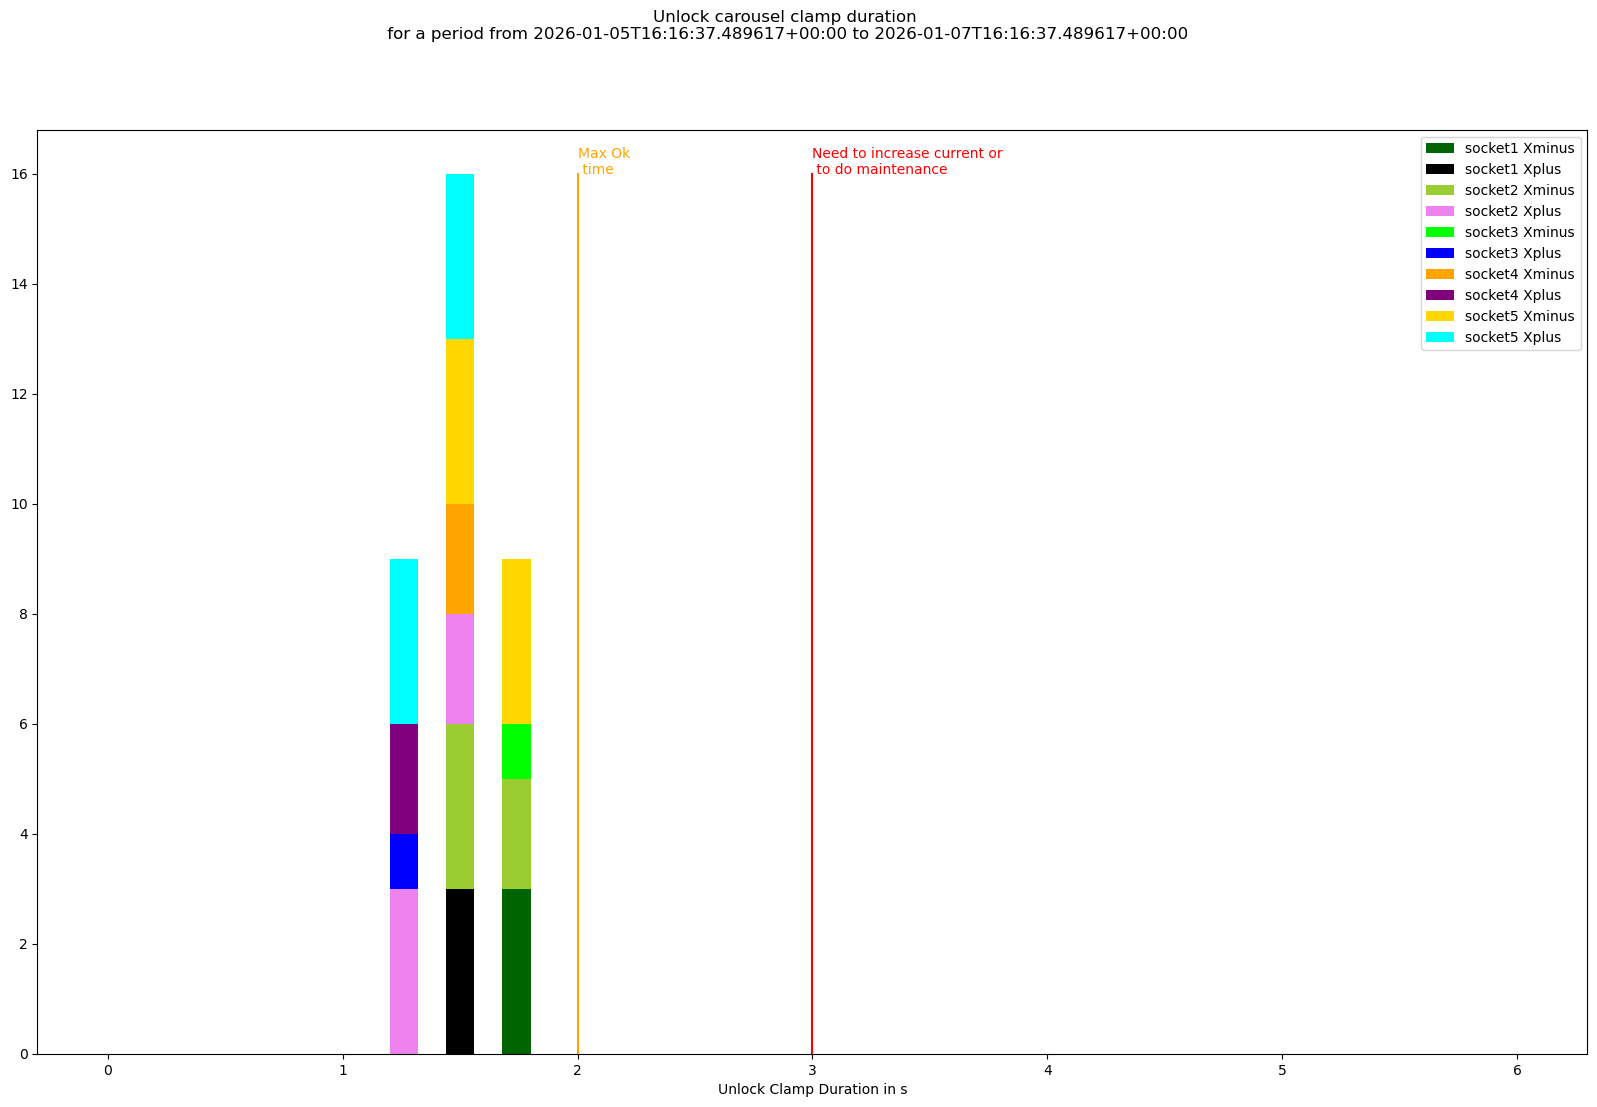

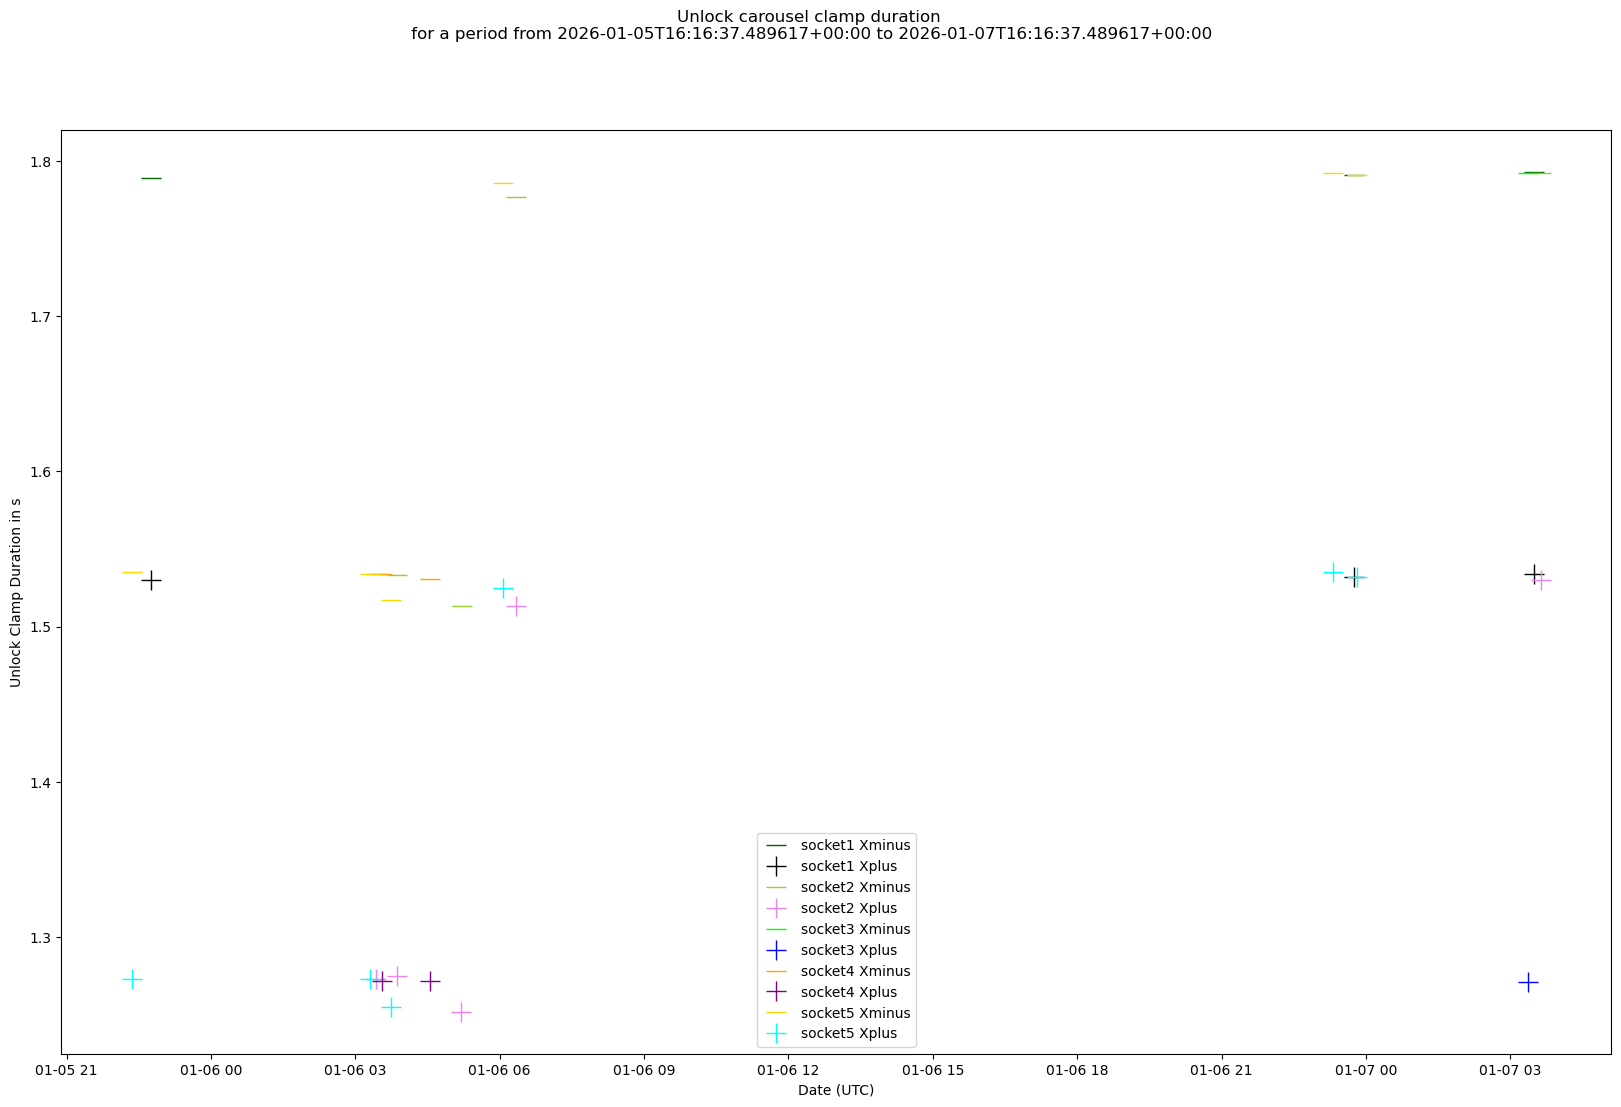

In [14]:
# Duration Plots 
color={'Xplus':['black','violet','b','purple','cyan'],'Xminus':['darkgreen','yellowgreen','lime','orange','gold']}
sym={'Xplus':'+','Xminus':'_'}
#
#
fig=plt.figure(figsize=(20,12))
title='Unlock carousel clamp duration \n for a period from %s to %s ' % (tstart,tend)
fig.suptitle(title)
#
a=[]
label=[]
colors=[]
for isock in range(1,6) : 
    for car_clamp in ['Xminus','Xplus'] :
        a.append(cl_duration[(cl_duration['UNLOCK'].notnull()) & (cl_duration['Socket']==socket_name[isock-1] )& (cl_duration['Clamp']==car_clamp )]['UNLOCK']/1000.)
        label.append(socket_name[isock-1]+' '+car_clamp)
        colors.append(color[car_clamp][isock-1])
ba,bb,bc=plt.hist(a,50,range=(0,6.),stacked=True,color=colors,label=label)
up_hist=np.max(ba)
if up_hist > 0. : 
    plt.plot([2,2],[0.,up_hist],color='orange')
    plt.text(2,up_hist,'Max Ok\n time',color='orange')    
    plt.plot([3,3],[0.,np.max(ba)],color='red')
    plt.text(3,up_hist,'Need to increase current or\n to do maintenance',color='red')
plt.xlabel('Unlock Clamp Duration in s') 
plt.legend()
if show_it : plt.show()
if save_fig : SaveFig(fig,File='UnlockClampDurationHist',run_cur=run_cur,raft_cur='ClampOnCarousel')
#
fig=plt.figure(figsize=(20,12))
title='Unlock carousel clamp duration \n for a period from %s to %s ' % (tstart,tend)
fig.suptitle(title)
#
for isock in range(1,6) : 
    for car_clamp in ['Xminus','Xplus'] :
        plt.plot(cl_duration[(cl_duration['UNLOCK'].notnull()) & (cl_duration['Socket']==socket_name[isock-1] )& (cl_duration['Clamp']==car_clamp )]['UNLOCK']/1000.,' ',marker=sym[car_clamp],color=color[car_clamp][isock-1],markersize=14,label=socket_name[isock-1]+' '+car_clamp)
plt.xlabel('Date (UTC)')
plt.ylabel('Unlock Clamp Duration in s') 
plt.legend()
if show_it : plt.show()
if save_fig : SaveFig(fig,File='UnlockClampDuration',run_cur=run_cur,raft_cur='ClampOnCarousel')
